# Sequential Testing in A/B Experiments

## Introduction
- Sequential Testing allows early stopping of an experiment without inflating false positives.
- Traditional A/B tests fix a sample size beforehand, but sequential testing lets you peek at results at regular intervals while adjusting for multiple looks.

## Type I Error Inflation (Why Multiple Looks Are Dangerous)  

If we check a hypothesis only once, the false positive rate is:  

$$
\alpha = 5\%
$$

However, if we check every day, the overall chance of a false positive is much higher:  

$$
\alpha_{\text{overall}} = 1 - (1 - \alpha)^{\text{number of tests}}
$$

🔹 **Example:** If we run a test for 30 days and check every day:  

$$
\alpha_{\text{overall}} = 1 - (1 - 0.05)^{30} \approx 0.79
$$

🚨 This means there's a **79% chance of a false positive**, even if the variant is ineffective!  


## Example Scenario:

An e-commerce company tests a new checkout design to see if it increases conversion rates (CVR). Instead of waiting for a fixed sample, they analyze results daily and stop early if the new design is significantly better.

- **Control Group** → Old Checkout
- **Test Group** → New Checkout

### Step 1: Simulating the Experiment Data

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

np.random.seed(42)

# Experiment parameters
days = 30   # Length of experiment
daily_visitors = 2000  # Number of visitors per day
true_cvr_control = 0.10  # True conversion rate for control (10%)
true_cvr_variant = 0.12  # True conversion rate for variant (12%)

# Simulate daily conversions
data = []
for day in range(1, days + 1):
    control_conversions = np.random.binomial(daily_visitors // 2, true_cvr_control)
    variant_conversions = np.random.binomial(daily_visitors // 2, true_cvr_variant)
    
    data.append([day, 'Control', control_conversions, daily_visitors // 2])
    data.append([day, 'Variant', variant_conversions, daily_visitors // 2])

df = pd.DataFrame(data, columns=['Day', 'Group', 'Conversions', 'Visitors'])
df.head()

,Day,Group,Conversions,Visitors
0,1,Control,96,1000
1,1,Variant,122,1000
2,2,Control,87,1000
3,2,Variant,103,1000
4,3,Control,111,1000


### Step 2: Running Sequential Tests (Z-Test at Each Step)

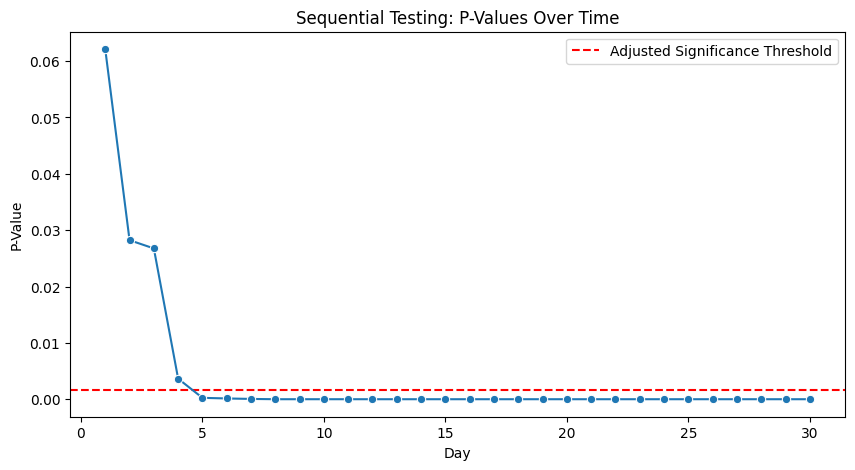

In [16]:
alpha = 0.05  # Significance level
stopping_threshold = alpha / days  # Adjusted threshold to control Type I error using Bonferroni Correction (conservertive but simple)
results = []

# Sequential testing loop
for day in range(1, days + 1):
    sub_df = df[df['Day'] <= day]
    
    conversions_control = sub_df[sub_df['Group'] == 'Control']['Conversions'].sum()
    visitors_control = sub_df[sub_df['Group'] == 'Control']['Visitors'].sum()
    
    conversions_variant = sub_df[sub_df['Group'] == 'Variant']['Conversions'].sum()
    visitors_variant = sub_df[sub_df['Group'] == 'Variant']['Visitors'].sum()

    # Perform Proportions Z-test
    stat, p_value = proportions_ztest([conversions_variant, conversions_control], 
                                      [visitors_variant, visitors_control])
    results.append({'Day': day, 'P-Value': p_value})

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plot p-values over time
plt.figure(figsize=(10,5))
plt.axhline(y=stopping_threshold, color='r', linestyle='--', label="Adjusted Significance Threshold")
sns.lineplot(x='Day', y='P-Value', data=results_df, marker='o')
plt.title("Sequential Testing: P-Values Over Time")
plt.xlabel("Day")
plt.ylabel("P-Value")
plt.legend()
plt.show()

### Step 3: Stopping Decision: Did We Find a Winner?

In [17]:
# Find the first day where p-value falls below thresholda
early_stop_day = results_df[results_df['P-Value'] < stopping_threshold]

if not early_stop_day.empty:
    print(f"Experiment stopped early on Day {early_stop_day.iloc[0]['Day']} (p={early_stop_day.iloc[0]['P-Value']:.5f})")
else:
    print("No significant result found, continue running the experiment.")

Experiment stopped early on Day 5.0 (p=0.00025)


## Why Use Sequential Testing?
- Allows early stopping if a significant effect is detected
- Reduces cost by not running unnecessary experiments
- Controls false positives using stopping thresholds